# Imbalanced datasets

In this kernel we will know some techniques to handle highly unbalanced datasets, with a focus on resampling. The Porto Seguro's Safe Driver Prediction competition, used in this kernel, is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.

Let's see how unbalanced the dataset is:

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')

In [5]:
df_train.shape

(595212, 59)

In [7]:
df_train.head(4)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0


In [9]:
target_count = df_train.target.value_counts()
target_count

0    573518
1     21694
Name: target, dtype: int64

class 0: 573518
class 1: 21694
proportion: 26.44


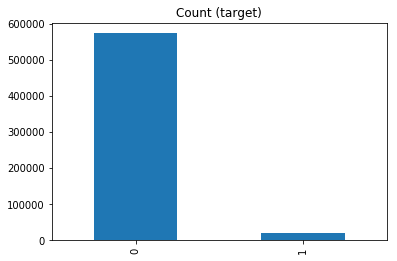

In [21]:
print('class 0:', target_count[0])
print('class 1:', target_count[1])
print('proportion:', round(target_count[0]/target_count[1], 2))
target_count.plot(kind='bar', title='Count (target)')

# The metric trap

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:


In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
X = df_train.drop(['id','target'],axis=1)
y = df_train.target

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [39]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. In this competition, the evaluation metric is the Normalized Gini Coefficient, a more robust metric for imbalanced datasets, that ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score.

# Confusion matrix

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.


Confusion matrix:
 [[114709      0]
 [  4334      0]]


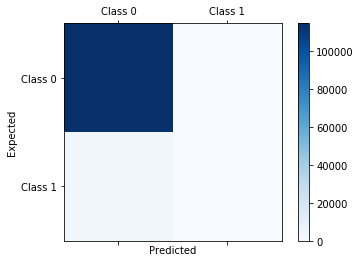

In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).


Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Let's implement a basic example, which uses the DataFrame.sample method to get random samples each class:


In [41]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

# Random under-sampling

In [44]:
df_class_0_under = df_class_0.sample(count_class_1)

In [46]:
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

Random under-sampling:
1    21694
0    21694
Name: target, dtype: int64


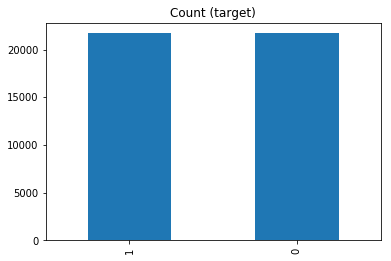

In [48]:
print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

# Random over-sampling

Random over sampling:
1    573518
0    573518
Name: target, dtype: int64


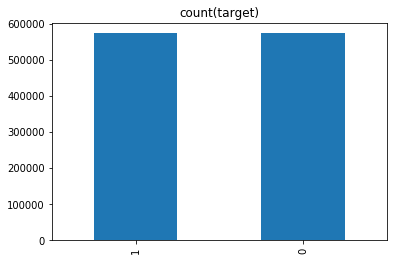

In [49]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='count(target)')

## Python imbalanced-learn module

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.


In [50]:
import imblearn

For ease of visualization, let's create a small unbalanced sample dataset using the make_classification method:

In [112]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9,0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

In [88]:
X.shape

(100, 20)

In [89]:
y.shape

(100,)

In [113]:
df = pd.DataFrame(X)

In [56]:
df.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.327419,-0.123936,0.377707,-0.650123,0.267562,1.228781,2.208772,-0.185977,0.238732,-2.565438,-0.383111,0.644056,0.104375,-1.703024,-0.510083,-0.108812,-0.230132,1.553707,1.497538,-1.476485
1,-0.843981,-0.018691,-0.841018,1.374583,0.157199,-0.599719,2.217041,-2.032194,-2.310214,-0.490477,-0.304583,1.360939,-1.844740,-0.341096,0.137243,1.704764,0.464255,1.225786,-0.842880,1.303258
2,-0.204642,0.472155,-0.140616,-2.902493,-1.513665,1.149545,2.283673,-0.809117,-1.723535,-0.958556,-0.259129,-0.279701,-1.431391,0.260146,-0.501306,-2.320545,0.422214,1.386474,-0.073335,0.586859
3,0.208274,-0.156982,0.063369,-0.545759,-0.395416,-2.679969,1.507772,0.391485,-0.487337,-0.946147,0.339852,-1.011854,-1.124795,0.347291,-1.078836,0.046923,-0.978324,1.100517,-0.697134,0.339577


In [114]:
df['target']=y

In [58]:
df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,0.327419,-0.123936,0.377707,-0.650123,0.267562,1.228781,2.208772,-0.185977,0.238732,-2.565438,...,0.644056,0.104375,-1.703024,-0.510083,-0.108812,-0.230132,1.553707,1.497538,-1.476485,0
1,-0.843981,-0.018691,-0.841018,1.374583,0.157199,-0.599719,2.217041,-2.032194,-2.310214,-0.490477,...,1.360939,-1.844740,-0.341096,0.137243,1.704764,0.464255,1.225786,-0.842880,1.303258,0
2,-0.204642,0.472155,-0.140616,-2.902493,-1.513665,1.149545,2.283673,-0.809117,-1.723535,-0.958556,...,-0.279701,-1.431391,0.260146,-0.501306,-2.320545,0.422214,1.386474,-0.073335,0.586859,0
3,0.208274,-0.156982,0.063369,-0.545759,-0.395416,-2.679969,1.507772,0.391485,-0.487337,-0.946147,...,-1.011854,-1.124795,0.347291,-1.078836,0.046923,-0.978324,1.100517,-0.697134,0.339577,0


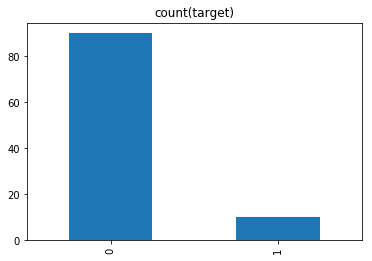

In [59]:
df.target.value_counts().plot(kind='bar', title='count(target)')

We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

In [115]:
x = df.drop(['target'], axis=1)

In [116]:
x.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.327419,-0.123936,0.377707,-0.650123,0.267562,1.228781,2.208772,-0.185977,0.238732,-2.565438,-0.383111,0.644056,0.104375,-1.703024,-0.510083,-0.108812,-0.230132,1.553707,1.497538,-1.476485
1,-0.843981,-0.018691,-0.841018,1.374583,0.157199,-0.599719,2.217041,-2.032194,-2.310214,-0.490477,-0.304583,1.360939,-1.844740,-0.341096,0.137243,1.704764,0.464255,1.225786,-0.842880,1.303258
2,-0.204642,0.472155,-0.140616,-2.902493,-1.513665,1.149545,2.283673,-0.809117,-1.723535,-0.958556,-0.259129,-0.279701,-1.431391,0.260146,-0.501306,-2.320545,0.422214,1.386474,-0.073335,0.586859
3,0.208274,-0.156982,0.063369,-0.545759,-0.395416,-2.679969,1.507772,0.391485,-0.487337,-0.946147,0.339852,-1.011854,-1.124795,0.347291,-1.078836,0.046923,-0.978324,1.100517,-0.697134,0.339577


In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(x)
print(x.shape)
print(projected.shape)

(100, 20)
(100, 2)


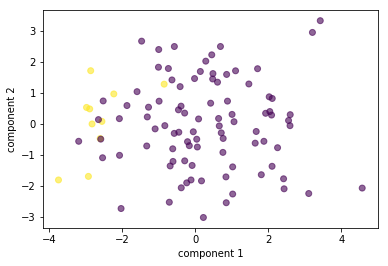

In [124]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=df.target, alpha=0.6)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

## Random under-sampling and over-sampling with imbalanced-learn

In [125]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(projected, y)

print('Removed indexes:', id_rus)

Removed indexes: [50 27 49 42 80 45 33  7 59 13  4  8  9 14 16 40 67 70 71 74]


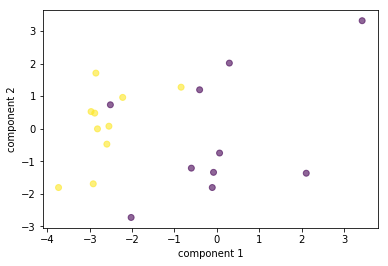

In [130]:
plt.scatter(X_rus[:, 0], X_rus[:, 1],
            c=y_rus, alpha=0.6)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [131]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(projected, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

80 new random picked points


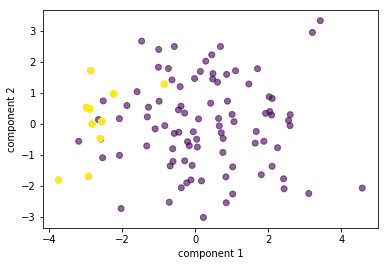

In [133]:
plt.scatter(X_ros[:, 0], X_ros[:, 1],
            c=y_ros, alpha=0.6)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()